In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get Data

In [2]:
with open('letter_ds.data') as f:
    rows = f.readlines()

In [3]:
labels = []
features = []
for row in rows:
    row_splited = row.split(' ')
    labels.append(row_splited[0])
    features.append({f.split(':')[0]: f.split(':')[1] for f in row_splited[1:] if len(f) > 0 and f != '\n'})

In [4]:
df = pd.DataFrame(features)
df = df.astype(float)
df['target'] = [int(l) for l in labels]

df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,target
0,-0.733333,-0.466667,-0.466667,-0.600000,-0.733333,-0.066667,0.066667,-0.733333,0.200000,0.466667,-0.066667,-0.066667,-0.866667,0.066667,-0.333333,-0.200000,26
1,-0.466667,-0.066667,-0.333333,-0.333333,-0.333333,-0.333333,0.200000,-0.200000,-0.466667,0.066667,-0.066667,0.200000,-0.733333,0.200000,-0.066667,0.333333,16
2,-0.066667,0.333333,0.066667,-0.066667,-0.466667,0.066667,0.066667,-0.333333,0.333333,0.466667,-0.733333,0.066667,-0.733333,-0.333333,-0.333333,0.333333,19
3,-0.466667,0.200000,-0.333333,-0.066667,-0.466667,-0.066667,-0.066667,0.733333,-0.866667,-0.066667,-0.200000,0.066667,-0.600000,0.066667,-1.000000,0.066667,8
4,-0.200000,-0.066667,0.066667,-0.333333,-0.466667,-0.066667,-0.200000,-0.600000,-0.066667,0.333333,-0.066667,0.200000,-0.600000,0.066667,-0.600000,-0.066667,8


In [5]:
df.groupby('target').count()[["1"]]

,1
target,
1,594
2,567
3,554
4,598
5,565
6,565
7,547
8,538
9,567


In [6]:
classes = list(set(df.target.values))

# Generate Unlabeled Data

## unlabeled classes
I ignore the labels of 20 random classes and treat them as unlabeled, this represent the fact that I don't have all the types of letters labeled in my dataset

In [7]:
import random

In [8]:
unlabeled_classes = random.sample(classes, k=20)
labeled_classes = [c for c in classes if c not in unlabeled_classes]

In [9]:
len(set(unlabeled_classes))

20

In [10]:
unlabeled_df = df[df.target.isin(unlabeled_classes)]
unlabeled_df['target'] = 0

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## sample labeled samples from labeled classes
this represent the fact that you don't know all the labels of all the  data and predict just some of them. if you had all the labeles so the client wouldn't need an algorithm to classify samples for this class.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
sample_ratio_options = [0.5]
def split_lableled_unlabeled(label_df):
    sample_ratio = random.choice(sample_ratio_options)
    labeled_df, unlabeled_df = train_test_split(label_df, train_size=sample_ratio)
    return labeled_df, unlabeled_df

In [13]:
labeled_dfs = []
unlabeled_dfs = []

for label in labeled_classes:
    label_df = df[df.target == label]
    labeled_df_new, unlabeled_df_new = split_lableled_unlabeled(label_df)
    labeled_dfs.append(labeled_df_new)
    unlabeled_dfs.append(unlabeled_df_new)
    
labeled_df = pd.concat(labeled_dfs)
unlabeled_df = pd.concat([unlabeled_df, pd.concat(unlabeled_dfs)])

In [14]:
unlabeled_df.groupby('target').count()[["1"]]

,1
target,
0,11604
7,274
8,269
12,280
13,304
19,282
22,291


## Train Algorithm

In [15]:
from lightgbm import LGBMClassifier

In [16]:
X_train, X_test, y_train, y_test = train_test_split(labeled_df.drop('target', axis=1), labeled_df['target'], test_size=0.2, stratify=labeled_df['target'].values)

In [17]:
model = LGBMClassifier(class_weight='balanced')

In [18]:
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

# Practical Example of the First Section

## Evaluate on test

In [19]:
from sklearn.metrics import classification_report

In [20]:
eval_test = pd.DataFrame(classification_report(y_test, model.predict(X_test), output_dict=True, target_names=[str(c) for c in model.classes_])).T
eval_test

,precision,recall,f1-score,support
7,0.932203,1.000000,0.964912,55.000000
8,0.962963,0.962963,0.962963,54.000000
12,1.000000,1.000000,1.000000,56.000000
13,0.952381,0.983607,0.967742,61.000000
19,1.000000,0.982143,0.990991,56.000000
22,1.000000,0.913793,0.954955,58.000000
accuracy,0.973529,0.973529,0.973529,0.973529
macro avg,0.974591,0.973751,0.973594,340.000000
weighted avg,0.974607,0.973529,0.973486,340.000000


Looks pretty good right?

## Evaluate on unlabeled

I ignored the evaluation on the '0' class because it doesn't exist in the train so it is all 0

In [21]:
eval_unlabeled = pd.DataFrame(classification_report(unlabeled_df['target'], model.predict(unlabeled_df.drop('target', axis=1)), output_dict=True, labels=model.classes_)).T
eval_unlabeled

,precision,recall,f1-score,support
7,0.095776,0.959854,0.174172,274.0
8,0.086276,0.962825,0.158361,269.0
12,0.233419,0.967857,0.376128,280.0
13,0.259162,0.976974,0.409655,304.0
19,0.090970,0.964539,0.166259,282.0
22,0.124391,0.965636,0.220392,291.0
micro avg,0.123497,0.966471,0.219008,1700.0
macro avg,0.148332,0.966281,0.250828,1700.0
weighted avg,0.150262,0.966471,0.253643,1700.0


in the recall you are right it is pretty good, In the precision Think again!

## Compare recall eval to precision eval

In [22]:
joined_eval = eval_unlabeled.join(eval_test, rsuffix = '_test', lsuffix='_unlabeled')

In [23]:
joined_eval

,precision_unlabeled,recall_unlabeled,f1-score_unlabeled,support_unlabeled,precision_test,recall_test,f1-score_test,support_test
7,0.095776,0.959854,0.174172,274.0,0.932203,1.000000,0.964912,55.0
8,0.086276,0.962825,0.158361,269.0,0.962963,0.962963,0.962963,54.0
12,0.233419,0.967857,0.376128,280.0,1.000000,1.000000,1.000000,56.0
13,0.259162,0.976974,0.409655,304.0,0.952381,0.983607,0.967742,61.0
19,0.090970,0.964539,0.166259,282.0,1.000000,0.982143,0.990991,56.0
22,0.124391,0.965636,0.220392,291.0,1.000000,0.913793,0.954955,58.0
micro avg,0.123497,0.966471,0.219008,1700.0,NaN,NaN,NaN,NaN
macro avg,0.148332,0.966281,0.250828,1700.0,0.974591,0.973751,0.973594,340.0
weighted avg,0.150262,0.966471,0.253643,1700.0,0.974607,0.973529,0.973486,340.0


In [24]:
joined_eval_1 = joined_eval.loc[[str(l) for l in labeled_classes] + ['macro avg']]
joined_eval_1[['precision_unlabeled', 'precision_test', 'recall_unlabeled', 'recall_test']]

,precision_unlabeled,precision_test,recall_unlabeled,recall_test
7,0.095776,0.932203,0.959854,1.000000
8,0.086276,0.962963,0.962825,0.962963
12,0.233419,1.000000,0.967857,1.000000
13,0.259162,0.952381,0.976974,0.983607
19,0.090970,1.000000,0.964539,0.982143
22,0.124391,1.000000,0.965636,0.913793
macro avg,0.148332,0.974591,0.966281,0.973751


I think I proved my point for the first section of the article

# Practical Example of the Second Section

In [25]:
def create_pred_df(df, label):
    pred_df = pd.DataFrame(model.predict_proba(df), columns=model.classes_)
    pred_df['index'] = df.index
    pred_df = pred_df.set_index('index')
    pred_df['target'] = label
    return pred_df

In [26]:
def recall_at_k_vs_k(y_test, y_pred, class_size, plot=True, class_name=None):
    k=0
    recall=np.zeros(len(y_test[y_test == 0]) + 1)
    curr_recall = 0
    
    y_pred_ind_sorted = np.argsort(y_pred.values)[::-1] # from largest prediction to smallest
    y_test_sorted = y_test.iloc[y_pred_ind_sorted].values
    
    pos_size = sum(y_test)
    for i in range(len(y_test)):
        if y_test_sorted[i] == 1:
            curr_recall += 1 / pos_size
        else:
            k += 1
        recall[k] = curr_recall
    ks = list(range(len(recall)))
    
    if plot:
        plt.plot(ks[:5 * class_size], recall[:5 * class_size], label='class: ' + str(class_name))
        plt.plot([class_size, class_size], [0,1], label='class_size: ' + str(class_size))
        plt.grid()
        plt.legend()
        plt.show()
        
    return ks, recall
        

In [27]:
def eval_precision_at_thresh(y_test, y_pred, class_size, thresh=0.5):
    curr_recall = 0
    curr_k = 0
    i=0
    pos_size = sum(y_test)


    y_pred_ind_sorted = np.argsort(y_pred.values)[::-1] # from largest prediction to smallest
    y_test_sorted = y_test.iloc[y_pred_ind_sorted].values
    y_pred_sorted = y_pred.iloc[y_pred_ind_sorted].values
    
    while y_pred_sorted[i] >= thresh:
        if y_test_sorted[i] == 1:
            curr_recall += 1 / pos_size
        else:
            curr_k += 1
        i += 1
    eval_precision = curr_recall * class_size / curr_k
    return eval_precision


In [28]:
class_sizes = dict(unlabeled_df.groupby('target').count()['1'])
class_sizes

{0: 11604, 7: 274, 8: 269, 12: 280, 13: 304, 19: 282, 22: 291}

In [29]:
test_pred_df = create_pred_df(X_test, y_test)
unlabeled_pred_df = create_pred_df(unlabeled_df.drop('target', axis=1), 0)
recall_at_k_calc_df = pd.concat([test_pred_df, unlabeled_pred_df])

## Plot recall@k vs. k curves, Calculate Evaluation for Precision

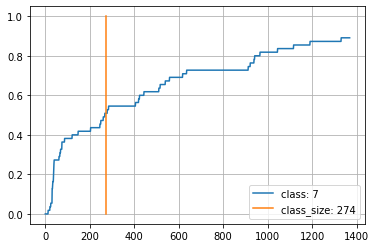

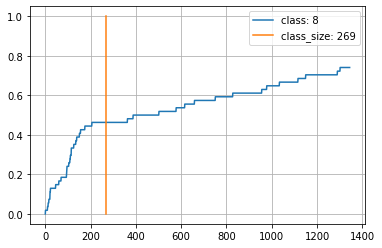

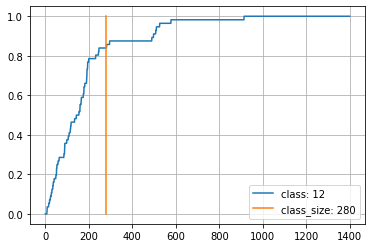

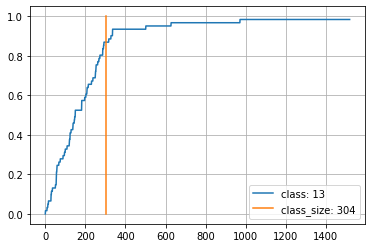

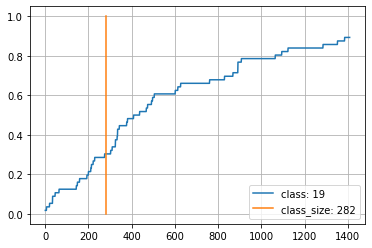

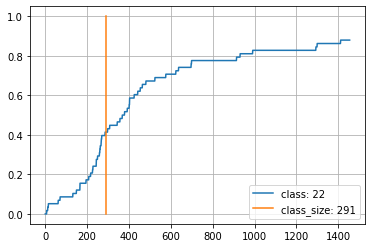

In [30]:
precision_evaluated = []
for class_to_predict in labeled_classes:
    one_vs_class_label = recall_at_k_calc_df.apply(lambda row: int(row['target'] == class_to_predict), axis=1)
    recall_at_k_vs_k(one_vs_class_label, recall_at_k_calc_df[class_to_predict], class_sizes[class_to_predict], class_name=class_to_predict)
    precision_evaluated.append(eval_precision_at_thresh(one_vs_class_label, recall_at_k_calc_df[class_to_predict], class_sizes[class_to_predict]))

## Create Eval df

In [73]:
recall_at_k_eval = pd.DataFrame()
recall_at_k_eval['label'] = [str(l) for l in labeled_classes]
recall_at_k_eval['precision_by_recall_at_k'] = precision_evaluated
macro_eval_df= pd.DataFrame([['macro avg', np.mean(precision_evaluated)]], columns=['label','precision_by_recall_at_k'])
recall_at_k_eval = pd.concat([recall_at_k_eval, macro_eval_df])
recall_at_k_eval = recall_at_k_eval.set_index('label')
recall_at_k_eval

,precision_by_recall_at_k
label,
7,0.105954
8,0.094990
12,0.261927
13,0.267936
19,0.097660
22,0.122654
macro avg,0.158520


## Compare Precision Evaluation

In [74]:
joined_eval_2 = joined_eval_1.join(recall_at_k_eval)

In [75]:
joined_eval_2[['precision_test', 'precision_unlabeled', 'precision_by_recall_at_k']]

,precision_test,precision_unlabeled,precision_by_recall_at_k
7,0.932203,0.095776,0.105954
8,0.962963,0.086276,0.094990
12,1.000000,0.233419,0.261927
13,0.952381,0.259162,0.267936
19,1.000000,0.090970,0.097660
22,1.000000,0.124391,0.122654
macro avg,0.974591,0.148332,0.158520


That is what I call good evaluation!!!

## Compare Precision Recall curve to the real ones

In [34]:
from sklearn.metrics import precision_recall_curve

In [35]:
def calc_evaled_precision_recall_curve(y_test, y_pred, class_size):
    pos_size = sum(y_test)
    curr_k = 0
    curr_recall = 0
    precision = []
    recall = []

    y_pred_ind_sorted = np.argsort(y_pred.values)[::-1] # from largest prediction to smallest
    y_test_sorted = y_test.iloc[y_pred_ind_sorted].values
    y_pred_sorted = y_pred.iloc[y_pred_ind_sorted].values
    
    for i in range(len(y_pred)):
        if y_test_sorted[i] == 1:
            curr_recall += 1 / pos_size
        else:
            curr_k += 1
            recall.append(curr_recall)
            curr_precision = curr_recall * class_size / curr_k
            precision.append(curr_precision)
    
    return precision, recall

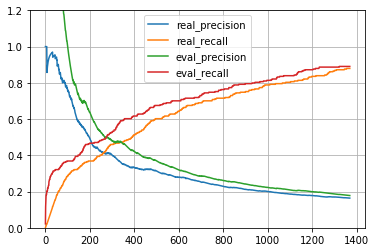

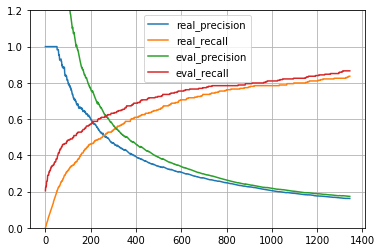

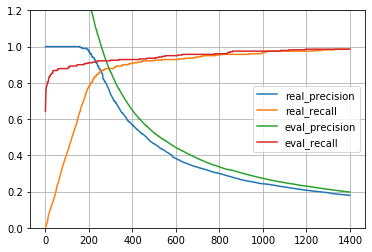

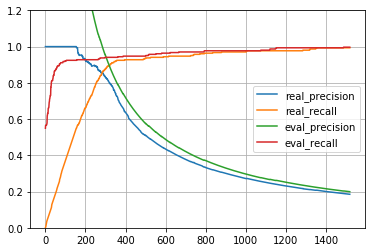

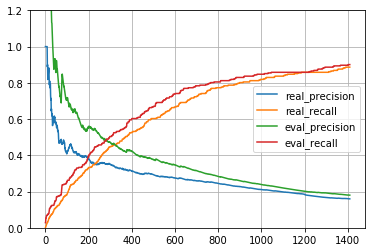

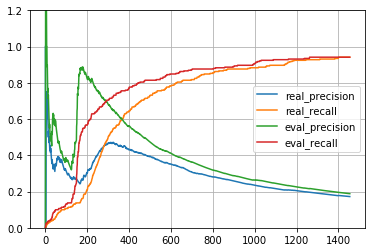

In [36]:
for class_to_predict in model.classes_:
    one_vs_class_label = unlabeled_df.apply(lambda row: int(row['target'] == class_to_predict), axis=1)
    y_pred_class = recall_at_k_calc_df.loc[unlabeled_df.index][class_to_predict]
    curr_precision, curr_recall, curr_thresh = precision_recall_curve(one_vs_class_label, y_pred_class)
    eval_precision, eval_recall = calc_evaled_precision_recall_curve(one_vs_class_label, y_pred_class, class_size=class_sizes[class_to_predict])
    
    plt.plot(curr_precision[::-1][:5 * class_sizes[class_to_predict]], label='real_precision')
    plt.plot(curr_recall[::-1][:5 * class_sizes[class_to_predict]], label='real_recall')    
    plt.plot(eval_precision[:5 * class_sizes[class_to_predict]], label='eval_precision')    
    plt.plot(eval_recall[:5 * class_sizes[class_to_predict]], label='eval_recall')
    plt.ylim((0,1.2))
    plt.legend()
    plt.grid()
    plt.show()
    
    

## Best Threshold by F1 Score
evaluating best decision boundry by best f1 score

In [37]:
def calc_best_thresh_by_eval_f1_score(y_test, y_pred, class_size, class_name, plot=True):
    best_f1_value = 0
    best_f1_index = 0
    best_f1_k = 0
    pos_size = sum(y_test)
    curr_k = 0
    curr_recall = 0
    precision = []
    recall = []
    f1 = []
    y_pred_ind_sorted = np.argsort(y_pred.values)[::-1] # from largest prediction to smallest
    y_test_sorted = y_test.iloc[y_pred_ind_sorted].values
    y_pred_sorted = y_pred.iloc[y_pred_ind_sorted].values
    
    for i in range(len(y_pred)):
        if y_test_sorted[i] == 1:
            curr_recall += 1 / pos_size
        else:
            curr_k += 1
            recall.append(curr_recall)
            curr_precision = curr_recall * class_size / curr_k
            precision.append(curr_precision)
            curr_f1 = 2 * curr_recall * curr_precision / (curr_recall + curr_precision)
            f1.append(curr_f1)
            if curr_f1 > best_f1_value:
                best_f1_value = curr_f1
                best_f1_index = i
                best_f1_k = curr_k
    
    f1_thresh = y_pred_sorted[best_f1_index]
    
    ks = list(range(len(recall)))
    if plot:
        print('best f1 value: ' + str(best_f1_value))
        plt.plot(ks[:5 * class_size], recall[:5 * class_size], label='recall')
        plt.plot(ks[:5 * class_size], precision[:5 * class_size], label='precision')
        plt.plot(ks[:5 * class_size], f1[:5 * class_size], label='f1')
        plt.plot([class_size, class_size], [0,1], label='class: ' + str(class_name) +' ,size: ' + str(class_size))
        plt.plot([best_f1_k, best_f1_k], [0,1], label='decision boundry')
        plt.ylim([0, 1.5])
        plt.grid()
        plt.legend()
        plt.show()

    
    return best_f1_value, f1_thresh, best_f1_value

best f1 value: 0.5780010045203416


C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


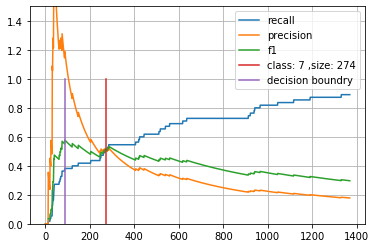

best f1 value: 0.5379064510519908


C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


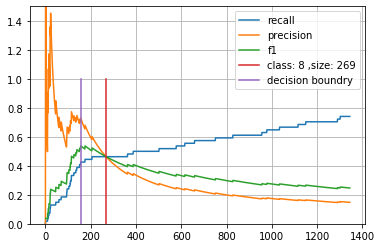

best f1 value: 0.9147609147609154


C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


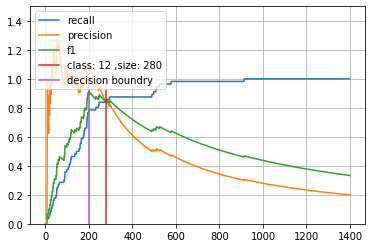

best f1 value: 0.8863200429656536


C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


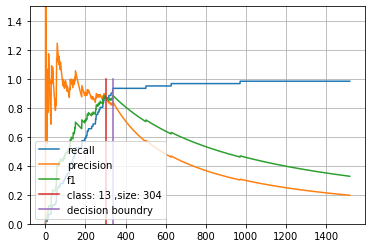

best f1 value: 0.43455402465554754


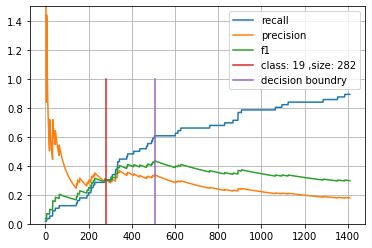

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


best f1 value: 0.5062675647945756


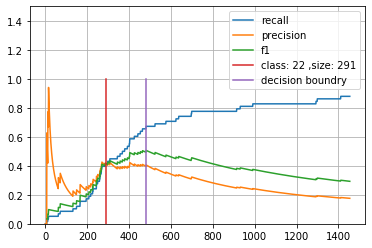

In [38]:
f1_evals = []
f1_threshs = []
f1_ests = []
for class_to_predict in model.classes_:
    one_vs_class_label = recall_at_k_calc_df.apply(lambda row: int(row['target'] == class_to_predict), axis=1)
    f1_score, f1_thresh, f1_est = calc_best_thresh_by_eval_f1_score(one_vs_class_label, recall_at_k_calc_df[class_to_predict], class_sizes[class_to_predict], class_name=class_to_predict)
    f1_evals.append(f1_score)
    f1_threshs.append(f1_thresh)
    f1_ests.append(f1_est)

In [39]:
classification_reports = []
for l in range(len(model.classes_)):
        classification_reports.append(pd.DataFrame(classification_report(unlabeled_df['target'],
                                                   model.classes_[l] *(model.predict_proba(unlabeled_df.drop('target', axis=1))[:, l] > f1_threshs[l]).astype(int),
                                                   output_dict=True, labels=[model.classes_[l]])).T.iloc[[0]])

In [40]:
eval_best_f1 = pd.concat(classification_reports)
eval_best_f1['f1-score_est'] = f1_ests
eval_best_f1

,precision,recall,f1-score,support,f1-score_est
7,0.804598,0.255474,0.387812,274.0,0.578001
8,0.660256,0.382900,0.484706,269.0,0.537906
12,0.990000,0.707143,0.825000,280.0,0.914761
13,0.809524,0.894737,0.850000,304.0,0.886320
19,0.302970,0.542553,0.388818,282.0,0.434554
22,0.413721,0.683849,0.515544,291.0,0.506268


In [41]:
eval_best_f1 = pd.concat(classification_reports)
eval_best_f1['f1-score_est'] = f1_ests
eval_best_f1 = eval_best_f1[['precision', 'recall', 'f1-score', 'f1-score_est', 'support']]
macro_eval_df= pd.DataFrame([[np.mean(eval_best_f1['precision'].values),
                              np.mean(eval_best_f1['recall'].values),
                              np.mean(eval_best_f1['f1-score'].values),
                              np.mean(eval_best_f1['f1-score_est'].values),
                              len(unlabeled_df)]], index=['macro avg'], columns=['precision', 'recall', 'f1-score', 'f1-score_est', 'support'])
eval_best_f1 = pd.concat([eval_best_f1, macro_eval_df])
eval_best_f1.columns = ['precision_f1', 'recall_f1', 'f1-score_f1', 'f1-score_est_f1', 'support_f1']
eval_best_f1

,precision_f1,recall_f1,f1-score_f1,f1-score_est_f1,support_f1
7,0.804598,0.255474,0.387812,0.578001,274.0
8,0.660256,0.382900,0.484706,0.537906,269.0
12,0.990000,0.707143,0.825000,0.914761,280.0
13,0.809524,0.894737,0.850000,0.886320,304.0
19,0.302970,0.542553,0.388818,0.434554,282.0
22,0.413721,0.683849,0.515544,0.506268,291.0
macro avg,0.663512,0.577776,0.575313,0.642968,13304.0


In [42]:
joined_eval_3 = joined_eval_2.join(eval_best_f1)
joined_eval_3[['precision_unlabeled', 'precision_f1', 'recall_unlabeled', 'recall_f1', 'f1-score_unlabeled', 'f1-score_f1', 'f1-score_est_f1']]

,precision_unlabeled,precision_f1,recall_unlabeled,recall_f1,f1-score_unlabeled,f1-score_f1,f1-score_est_f1
7,0.095776,0.804598,0.959854,0.255474,0.174172,0.387812,0.578001
8,0.086276,0.660256,0.962825,0.382900,0.158361,0.484706,0.537906
12,0.233419,0.990000,0.967857,0.707143,0.376128,0.825000,0.914761
13,0.259162,0.809524,0.976974,0.894737,0.409655,0.850000,0.886320
19,0.090970,0.302970,0.964539,0.542553,0.166259,0.388818,0.434554
22,0.124391,0.413721,0.965636,0.683849,0.220392,0.515544,0.506268
macro avg,0.148332,0.663512,0.966281,0.577776,0.250828,0.575313,0.642968


Big improvement!

## Compare threshold to best threshold

In [43]:
from sklearn.metrics import f1_score

In [44]:
def find_best_f1(y_test, y_pred):
    best_f1 = 0
    best_thresh = 0
    true_count = 0
    y_pred_ind_sorted = np.argsort(y_pred.values)[::-1] # from largest prediction to smallest
    y_test_sorted = y_test.iloc[y_pred_ind_sorted].values
    y_pred_sorted = y_pred.iloc[y_pred_ind_sorted].values
    
    for i in range(len(y_pred)):
        if y_test_sorted[i]:
            true_count += 1
    
    for thresh in y_pred_sorted:
        y_pred_curr = (y_pred > thresh).astype(int)
        curr_f1 = f1_score(y_test, y_pred_curr)
        if curr_f1 > best_f1:
            best_f1 = curr_f1
            best_thresh = thresh
    return best_f1, best_thresh

In [45]:
class_to_predict = model.classes_[0]
one_vs_class_label = unlabeled_df.apply(lambda row: int(row['target'] == class_to_predict), axis=1)
y_pred_class = recall_at_k_calc_df.loc[unlabeled_df.index][class_to_predict]

In [46]:
f1_scores_class = []
f1_threshs_class = []
for class_to_predict in model.classes_:
    one_vs_class_label = unlabeled_df.apply(lambda row: int(row['target'] == class_to_predict), axis=1)
    y_pred_class = recall_at_k_calc_df.loc[unlabeled_df.index][class_to_predict]
    curr_precision, curr_recall, curr_thresh = precision_recall_curve(one_vs_class_label, y_pred_class)
    curr_f1_scores = [2 * p * r / (p + r) for p, r in zip(curr_precision, curr_recall)]
    curr_max_f1, curr_max_f1_index = max(curr_f1_scores), np.argmax(curr_f1_scores)    
    f1_scores_class.append(curr_max_f1)
    f1_threshs_class.append(curr_thresh[curr_max_f1_index])

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [47]:
compare_desicion_boundries_df = pd.DataFrame(zip(f1_scores_class, list(joined_eval_3['f1-score_f1']), f1_threshs_class, f1_threshs),
                                             columns=['optimal_f1', 'est_thresh_f1', 'optimal_thresh', 'est_thresh'],
                                             index=model.classes_)
compare_desicion_boundries_df

,optimal_f1,est_thresh_f1,optimal_thresh,est_thresh
7,0.435443,0.387812,0.999645,0.999690
8,0.526767,0.484706,0.999175,0.999374
12,0.879245,0.825000,0.993611,0.999136
13,0.859477,0.850000,0.996135,0.992975
19,0.400477,0.388818,0.998703,0.999019
22,0.526619,0.515544,0.999943,0.999550


# Cross Validation Prediction

In [48]:
from sklearn.model_selection import cross_val_predict

In [49]:
from sklearn.multiclass import OneVsRestClassifier

In [50]:
def create_pred_df_cross_val(df, label, model=OneVsRestClassifier(LGBMClassifier(class_weight = 'balanced'), n_jobs=-2)):
    predictions = cross_val_predict(model, df, label, cv=10, method='predict_proba')
    pred_df = pd.DataFrame(predictions, columns=[0] + labeled_classes)
    pred_df['index'] = df.index
    pred_df = pred_df.set_index('index')
    pred_df['target'] = label
    return pred_df

In [51]:
unlabeled_no_labels = unlabeled_df.copy()
unlabeled_no_labels['target'] = 0
df_to_predict_cross_val = pd.concat([labeled_df, unlabeled_no_labels])

In [52]:
pred_cross_val = pd.DataFrame()
pred_cross_val['index'] = df_to_predict_cross_val.index
pred_cross_val['prediction'] = cross_val_predict(OneVsRestClassifier(LGBMClassifier(class_weight = 'balanced'), n_jobs=-2),
                                                 df_to_predict_cross_val.drop('target', axis=1), df_to_predict_cross_val['target'], cv=10, method='predict')
pred_cross_val = pred_cross_val.set_index('index')

# Model Evaluation

In [53]:
eval_unlabeled_cross_val = pd.DataFrame(classification_report(unlabeled_df['target'], pred_cross_val.loc[unlabeled_df.index]['prediction'], output_dict=True, labels=model.classes_)).T
eval_unlabeled_cross_val

,precision,recall,f1-score,support
7,0.903226,0.919708,0.911392,274.0
8,0.822642,0.810409,0.816479,269.0
12,0.969231,0.900000,0.933333,280.0
13,0.945513,0.970395,0.957792,304.0
19,0.919014,0.925532,0.922261,282.0
22,0.938776,0.948454,0.943590,291.0
micro avg,0.917355,0.914118,0.915734,1700.0
macro avg,0.916400,0.912416,0.914141,1700.0
weighted avg,0.917612,0.914118,0.915599,1700.0


In [54]:
eval_unlabeled_cross_val = eval_unlabeled_cross_val.loc[joined_eval_3.index]

much better precision and f1, let's see how the recall@k vs. k improved from previous model

# Eval of cross val prediction vs. regular prediction
## recall at k eval

In [55]:
cross_val_pred_df = create_pred_df_cross_val(df_to_predict_cross_val.drop('target', axis=1), df_to_predict_cross_val['target'])
cross_val_pred_df = cross_val_pred_df.loc[recall_at_k_calc_df.index]

In [57]:
from sklearn.metrics import roc_auc_score

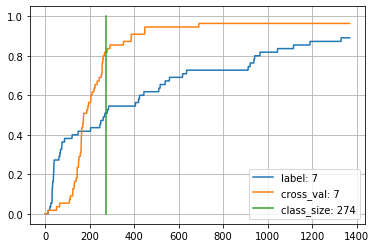

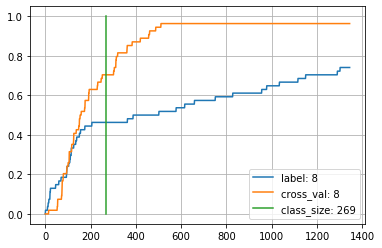

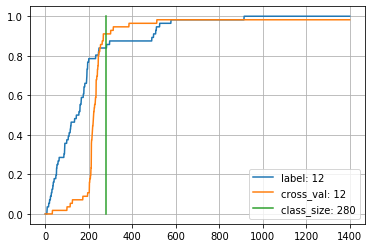

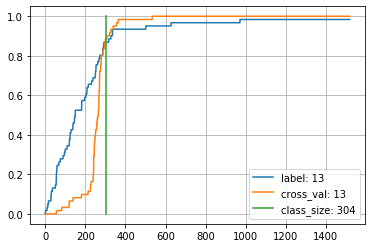

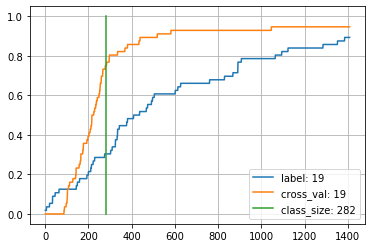

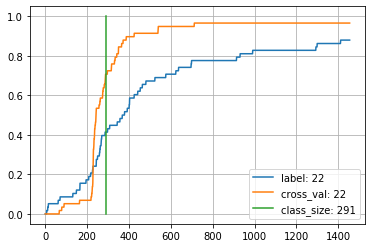

In [78]:
roc_auc_label = []
roc_auc_cv = []

for class_to_predict in labeled_classes:
    # recall@k only labeled algorithm
    one_vs_class_label = recall_at_k_calc_df.apply(lambda row: int(row['target'] == class_to_predict), axis=1)
    ks_label, recall_label = recall_at_k_vs_k(one_vs_class_label, recall_at_k_calc_df[class_to_predict], class_sizes[class_to_predict], class_name=class_to_predict, plot=False)
    roc_auc_label.append(roc_auc_score(one_vs_class_label, recall_at_k_calc_df[class_to_predict]))
    
    # recall@k only cross_val algorithm
    one_vs_class_label = recall_at_k_calc_df.apply(lambda row: int(row['target'] == class_to_predict), axis=1)
    ks_unlabeled, recall_unlabeled = recall_at_k_vs_k(one_vs_class_label, cross_val_pred_df[class_to_predict], class_sizes[class_to_predict], class_name=class_to_predict, plot=False)
    roc_auc_cv.append(roc_auc_score(one_vs_class_label, cross_val_pred_df[class_to_predict]))
    
    plt.plot(ks_label[:5 * class_sizes[class_to_predict]], recall_label[:5 * class_sizes[class_to_predict]], label='label: ' + str(class_to_predict))
    plt.plot(ks_unlabeled[:5 * class_sizes[class_to_predict]], recall_unlabeled[:5 * class_sizes[class_to_predict]], label='cross_val: ' + str(class_to_predict))
    
    plt.plot([class_sizes[class_to_predict], class_sizes[class_to_predict]], [0,1], label='class_size: ' + str(class_sizes[class_to_predict]))
    plt.grid()
    plt.legend()
    plt.show()
    

## F1 Thresh Eval
you will see that by using this algorithm the threshold is close to be optimal, the evaluation of threshold makes f1 a bit worse

In [59]:
def calc_best_thresh_by_eval_f1_score(y_test, y_pred, class_size, class_name, plot=True):
    best_f1_value = 0
    best_f1_index = 0
    best_f1_k = 0
    pos_size = sum(y_test)
    curr_k = 0
    curr_recall = 0
    precision = []
    recall = []
    f1 = []
    y_pred_ind_sorted = np.argsort(y_pred.values)[::-1] # from largest prediction to smallest
    y_test_sorted = y_test.iloc[y_pred_ind_sorted].values
    y_pred_sorted = y_pred.iloc[y_pred_ind_sorted].values
    
    for i in range(len(y_pred)):
        if y_test_sorted[i] == 1:
            curr_recall += 1 / pos_size
        else:
            curr_k += 1
            recall.append(curr_recall)
            curr_precision = curr_recall * class_size / curr_k
            precision.append(curr_precision)
            curr_f1 = 2 * curr_recall * curr_precision / (curr_recall + curr_precision)
            f1.append(curr_f1)
            if curr_f1 > best_f1_value:
                best_f1_value = curr_f1
                best_f1_index = i
                best_f1_k = curr_k
    
    f1_thresh = y_pred_sorted[best_f1_index]
    
    ks = list(range(len(recall)))
    if plot:
        print('best f1 value: ' + str(best_f1_value))
        plt.plot(ks[:5 * class_size], recall[:5 * class_size], label='recall')
        plt.plot(ks[:5 * class_size], precision[:5 * class_size], label='precision')
        plt.plot(ks[:5 * class_size], f1[:5 * class_size], label='f1')
        plt.plot([class_size, class_size], [0,1], label='class: ' + str(class_name) +' ,size: ' + str(class_size))
        plt.plot([best_f1_k, best_f1_k], [0,1], label='decision boundry')
        plt.ylim([0, 1.5])
        plt.grid()
        plt.legend()
        plt.show()

    
    return best_f1_value, f1_thresh, best_f1_value

In [60]:
f1_evals = []
f1_threshs = []
f1_ests = []
for class_to_predict in model.classes_:
    one_vs_class_label = cross_val_pred_df.apply(lambda row: int(row['target'] == class_to_predict), axis=1)
    f1_score, f1_thresh, f1_est = calc_best_thresh_by_eval_f1_score(one_vs_class_label, cross_val_pred_df[class_to_predict], class_sizes[class_to_predict], class_name=class_to_predict, plot=False)
    f1_evals.append(f1_score)
    f1_threshs.append(f1_thresh)
    f1_ests.append(f1_est)

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [61]:
classification_reports = []
for l in range(len(model.classes_)):
        classification_reports.append(pd.DataFrame(classification_report(unlabeled_df['target'],
                                                   model.classes_[l] * (cross_val_pred_df.loc[unlabeled_df.index][model.classes_[l]].values > f1_threshs[l]).astype(int),
                                                   output_dict=True, labels=[model.classes_[l]])).T.iloc[[0]])

In [62]:
eval_best_f1_cv = pd.concat(classification_reports)
eval_best_f1_cv['f1-score_est'] = f1_ests
eval_best_f1_cv = eval_best_f1_cv[['precision', 'recall', 'f1-score', 'f1-score_est', 'support']]
eval_best_f1_cv

,precision,recall,f1-score,f1-score_est,support
7,0.868966,0.919708,0.893617,0.827369,274.0
8,0.712500,0.847584,0.774194,0.743001,269.0
12,0.951311,0.907143,0.928702,0.930657,280.0
13,0.882006,0.983553,0.930016,0.897668,304.0
19,0.892256,0.939716,0.915371,0.781404,282.0
22,0.760108,0.969072,0.851964,0.770721,291.0


In [63]:
macro_eval_df_cv= pd.DataFrame([[np.mean(eval_best_f1_cv['precision'].values),
                              np.mean(eval_best_f1_cv['recall'].values),
                              np.mean(eval_best_f1_cv['f1-score'].values),
                              np.mean(eval_best_f1_cv['f1-score_est'].values),
                              len(unlabeled_df)]], index=['macro avg'], columns=['precision', 'recall', 'f1-score', 'f1-score_est', 'support'])
eval_best_f1_cv = pd.concat([eval_best_f1_cv, macro_eval_df_cv])
#eval_best_f1_cv.columns = ['precision_f1_est', 'recall_f1_est', 'f1-score_f1_est', 'f1-score_est_f1_est', 'support_est']
compare_df = eval_best_f1_cv.join(eval_unlabeled_cross_val, lsuffix='_est', rsuffix='_cv')
compare_df

,precision_est,recall_est,f1-score_est,f1-score_est,support_est,precision_cv,recall_cv,f1-score_cv,support_cv
7,0.868966,0.919708,0.893617,0.827369,274.0,0.903226,0.919708,0.911392,274.0
8,0.712500,0.847584,0.774194,0.743001,269.0,0.822642,0.810409,0.816479,269.0
12,0.951311,0.907143,0.928702,0.930657,280.0,0.969231,0.900000,0.933333,280.0
13,0.882006,0.983553,0.930016,0.897668,304.0,0.945513,0.970395,0.957792,304.0
19,0.892256,0.939716,0.915371,0.781404,282.0,0.919014,0.925532,0.922261,282.0
22,0.760108,0.969072,0.851964,0.770721,291.0,0.938776,0.948454,0.943590,291.0
macro avg,0.844524,0.927796,0.882311,0.825137,13304.0,0.916400,0.912416,0.914141,1700.0


so, this threshold choosing is not needed because you can see now that the f1 got slightly worse

In [64]:
eval_cv_final = compare_df[['precision_cv', 'recall_cv', 'f1-score_cv']]

In [65]:
joined_eval_4 = joined_eval_3.join(eval_cv_final, rsuffix='_cv')
joined_eval_4[['precision_cv', 'precision_f1', 'recall_cv', 'recall_f1', 'f1-score_cv', 'f1-score_f1']]

,precision_cv,precision_f1,recall_cv,recall_f1,f1-score_cv,f1-score_f1
7,0.903226,0.804598,0.919708,0.255474,0.911392,0.387812
8,0.822642,0.660256,0.810409,0.382900,0.816479,0.484706
12,0.969231,0.990000,0.900000,0.707143,0.933333,0.825000
13,0.945513,0.809524,0.970395,0.894737,0.957792,0.850000
19,0.919014,0.302970,0.925532,0.542553,0.922261,0.388818
22,0.938776,0.413721,0.948454,0.683849,0.943590,0.515544
macro avg,0.916400,0.663512,0.912416,0.577776,0.914141,0.575313
